<a href="https://colab.research.google.com/github/JarnovdKolk/Test/blob/main/Handson4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# to reduce the deprecation warnings
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc, confusion_matrix, roc_curve

#Importing plotting package doesn't work
def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix"

    # Compute confusion matrix
    if len(y_true.shape) > 1 and len(y_pred.shape) > 1:
        cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    else:
        cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap, origin="lower")
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label(title)

    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        ylabel="True label",
        xlabel="Predicted label",
    )

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


def plot_roc(fpr, tpr, auc, labels, linestyle, legend=True):
    for label in labels:
        plt.plot(
            tpr[label],
            fpr[label],
            label=f"{label.replace('j_', '')}, AUC = {auc[label] * 100:.1f}%",
            linestyle=linestyle,
        )
    plt.semilogy()
    plt.xlabel("True positive rate")
    plt.ylabel("False positive rate")
    plt.ylim(0.001, 1)
    plt.grid(True)
    if legend:
        plt.legend(loc="upper left")


def roc_data(y, predict_test, labels):

    df = pd.DataFrame()

    fprs = {}
    tprs = {}
    aucs = {}

    for i, label in enumerate(labels):
        df[label] = y[:, i] if len(labels) > 1 else y
        df[f"{label}_pred"] = predict_test[:, i] if len(labels) > 1 else predict_test

        fprs[label], tprs[label], _ = roc_curve(df[label], df[f"{label}_pred"])

        aucs[label] = auc(fprs[label], tprs[label])
    return fprs, tprs, aucs


def make_roc(y, predict_test, labels, linestyle="-", legend=True):

    if "j_index" in labels:
        labels.remove("j_index")

    fprs, tprs, aucs = roc_data(y, predict_test, labels)
    plot_roc(fprs, tprs, aucs, labels, linestyle, legend=legend)


def normalize_image(image):
    """Rescale the constrast in an image based on the noise (used for displays and the CNN)"""
    sigmaG_coeff = 0.7413
    image = image.reshape(21, 21)

    per25, per50, per75 = np.percentile(image, [25, 50, 75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    # sigma clip image, remove background, and normalize to unity
    image[image < (per50 - 2 * sigmaG)] = per50 - 2 * sigmaG
    image -= np.min(image)
    image /= np.sum(image)

    return image


def plot_image_array(
    images, nrows=2, ncols=5, figsize=[8, 4], nx=21, ny=21, title="", subtitle=False, class_true=None, classes=None
):
    """Plot an array of images"""
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows * ncols):
        i = int(indx / ncols)
        j = indx % ncols
        if i == 0:
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if j != 0:
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx, ny), cmap="gray", origin="lower")
        if subtitle:
            ax[i][j].set_title(
                (
                    f"True class: {np.argmax(class_true[indx])}, "
                    + f"Predicted class: {np.argmax(classes[indx])}\n"
                    + f"Prob(class 1): {classes[indx, 1]}"
                )
            )

    fig.suptitle(title)
    ax[0][0].set_ylabel("$y$")
    ax[nrows - 1][int(ncols / 2)].set_xlabel("$x$")


def plot_model_history(history):
    """Plot the training and validation history for a TensorFlow network"""

    # Extract loss and accuracy
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    n_epochs = len(loss)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].plot(np.arange(n_epochs), loss, label="Training")
    ax[0].plot(np.arange(n_epochs), val_loss, label="Validation")
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")

    ax[1].plot(np.arange(n_epochs), acc, label="Training")
    ax[1].plot(np.arange(n_epochs), val_acc, label="Validation")
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")

In [5]:
# Brute force direct downloads source and noise images to circumvent size limitations
# for google drive internal virus scan. Download may take some time.

import os
import requests

files = {
    "noise": (os.path.join("data", "stamps_noise.npy"), "1UT2BCf-IDUEpvTmcU4bq6nDcY3Ayw5vJ"),
    "sources": (os.path.join("data", "stamps_sources.npy"), "1cZaMCA0z_nPX6GB_meLGouwOidEROcwc"),
}

for name, file_id in files.values():
    if not os.path.exists(name):
        print(f"Downloading file {name}.")

        os.makedirs(os.path.dirname(name), exist_ok=True)
        url = f"https://docs.google.com/uc?export=download&id={file_id}&confirm=t"
        response = requests.post(url)
        with open(name, "wb") as file:
            file.write(response.content)
    print(f"File {name} is downloaded")

sources = np.load(files["sources"][0])
noise = np.load(files["noise"][0])

File data/stamps_noise.npy is downloaded
File data/stamps_sources.npy is downloaded


In [6]:
# normalizing images

point_source_stamps = []
for image in sources:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise:
    no_point_source_stamps.append(normalize_image(image))

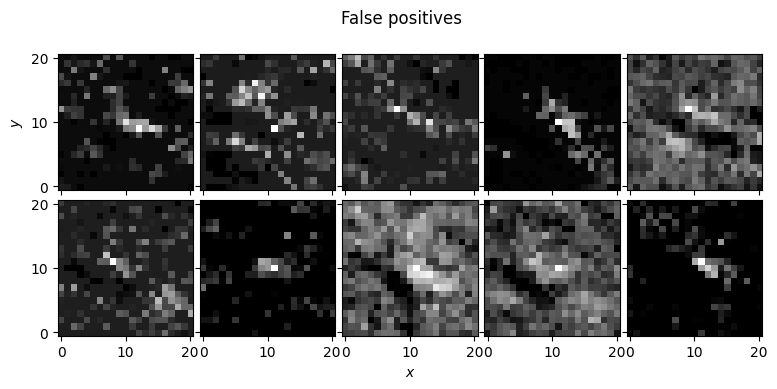

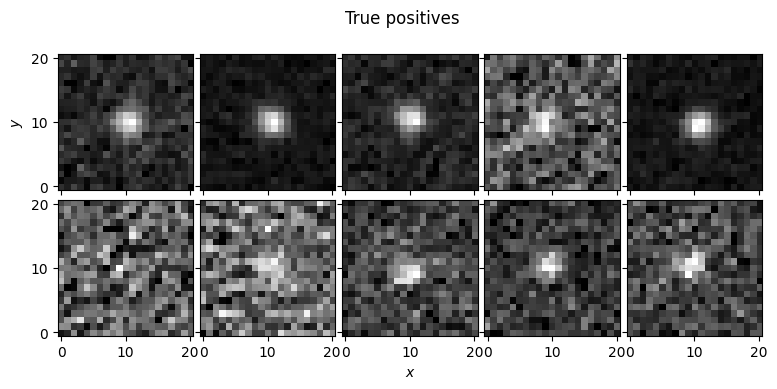

In [4]:
# plot sample of images
plot_image_array(no_point_source_stamps, title="False positives")
plot_image_array(point_source_stamps, title="True positives")

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


def reshape_arrays(data, labels):
    """reshape arrays for Keras"""
    data = data.reshape(-1, 21, 21, 1)
    labels = to_categorical(labels)
    return data, labels


# combine the false positives and true positives
input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps) :] = 1  # 0 for noise, 1 for a star

# split the samples into training, validation and, test data sets:
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2
# Note: we have to use train_test_split twice
# Split the data into training+validation and test sets, stratifying by stamp_class
data_train_val, data_test, class_train_val, class_test = train_test_split(
    input_stamps, stamp_class, test_size=test_frac, random_state=42, stratify=stamp_class
)

# Split the training+validation set into training and validation sets,
# stratifying by class_train_val
data_train, data_val, class_train, class_val = train_test_split(
    data_train_val, class_train_val,
    test_size=val_frac / (train_frac + val_frac),
    random_state=42,
    stratify=class_train_val
)

# Reshape arrays as before
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)


print(
    f"Number of samples in the training ({data_train.shape[0]}); test ({data_test.shape[0]}); and validation ({data_val.shape[0]}) data sets"
)

print(
    f"Fraction of true samples in the training ({np.sum(class_train[:,0])/data_train.shape[0]}); test ({np.sum(class_test[:,0])/data_test.shape[0]}); and validation ({np.sum(class_val[:,0])/data_val.shape[0]}) data sets"
)

Number of samples in the training (76665); test (21905); and validation (10953) data sets
Fraction of true samples in the training (0.4521620035218157); test (0.4521798676101347); and validation (0.45220487537660914) data sets


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def simple(input_shape=(21, 21, 1), n_classes: int = 2):

    model = Sequential(name="simple")

    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    model.add(Dense(30, input_shape=input_shape, activation="relu", name="fc_1"))

    model.add(Dense(30, activation="relu", name="fc_2"))

    # output layer
    model.add(Flatten(name="flatten_1"))
    activation = "sigmoid" if n_classes == 1 else "softmax"
    model.add(Dense(n_classes, activation=activation, name="fc_out"))

    return model
# Output the structure of the model
simple_model = simple()
simple_model.summary()

n_epochs = 50
batch_size = 1024
simple_model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

from sklearn.utils.class_weight import compute_class_weight

# Ensure stamp_class is a NumPy array
stamp_class = np.array(stamp_class)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=stamp_class)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

simple_model_history=simple_model.fit(
    data_train, class_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(data_val, class_val),
    shuffle=True,
    class_weight=class_weight_dict
)

#simple_model_history = simple_model.fit(
#    data_train,
#    class_train,
#    epochs=n_epochs,
#    batch_size=batch_size,
#    verbose=0,
#    validation_data=(data_val, class_val),
#    shuffle=True,)

Model: "simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fc_1 (Dense)                         │ (None, 21, 21, 30)          │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 21, 21, 30)          │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 13230)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_out (Dense)                       │ (None, 2)                   │          26,462 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,452 (107.23 KB)

 Trainable params: 27,452 (107.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5692 - loss: 0.6931 - val_accuracy: 0.6709 - val_loss: 0.6931
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5419 - loss: 0.6932 - val_accuracy: 0.6470 - val_loss: 0.6930
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5413 - loss: 0.6932 - val_accuracy: 0.5651 - val_loss: 0.6930
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5671 - loss: 0.6932 - val_accuracy: 0.5558 - val_loss: 0.6929
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5730 - loss: 0.6934 - val_accuracy: 0.5731 - val_loss: 0.6930
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5593 - loss: 0.6928 - val_accuracy: 0.4506 - val_loss: 0.6931
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4555 - loss: 0.6934 - val_accuracy: 0.5542 - val_loss: 0.6929
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5573 - loss: 0.6930 - val_accuracy: 0.6607 - val

[[0.5003272  0.49967277]
 [0.49976316 0.5002368 ]
 [0.5003932  0.49960682]
 ...
 [0.5006321  0.4993679 ]
 [0.49996632 0.5000337 ]
 [0.50001967 0.49998036]]


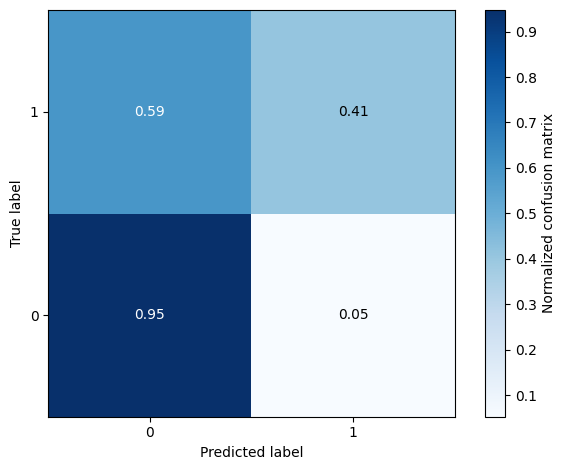

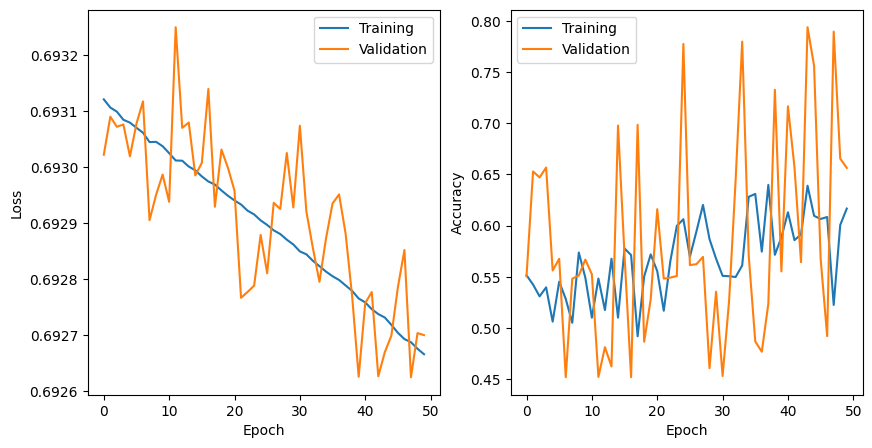

In [29]:
# use the network to predict class values
classes = simple_model.predict(data_test, verbose=0)
print(classes)
# plot the confusion matrix
plot_confusion_matrix(np.argmax(class_test, axis=1), np.argmax(classes, axis=1), normalize=True)
# plot the training history of the network
plot_model_history(simple_model_history)

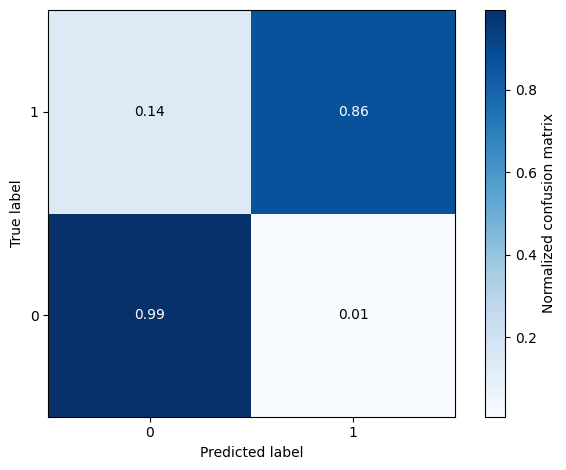

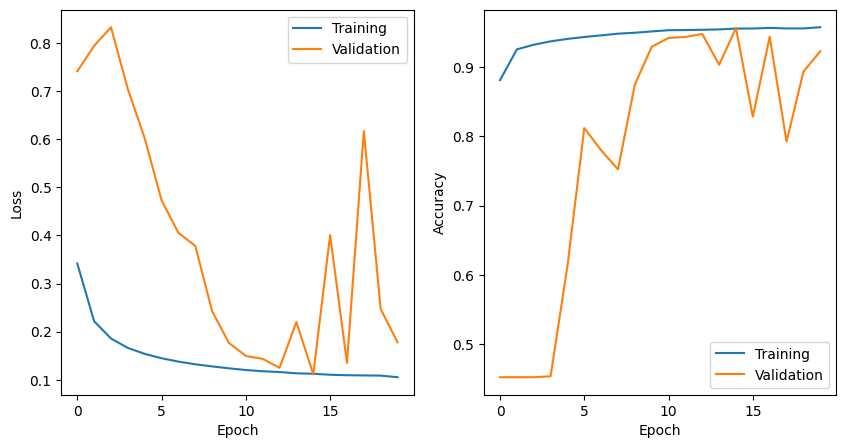

In [30]:
from tensorflow.keras.layers import BatchNormalization


def simpleBN(input_shape=(21, 21, 1), n_classes: int = 2):

    model = Sequential(name="simple")

    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    model.add(Dense(30, input_shape=input_shape, activation="relu", name="fc_1"))
    model.add(BatchNormalization(axis=3, name = 'bn_1'))
    model.add(Dense(30, activation="relu", name="fc_2"))
    model.add(BatchNormalization(axis=3, name = 'bn_2'))

    # output layer
    model.add(Flatten())
    activation = "sigmoid" if n_classes == 1 else "softmax"
    model.add(Dense(n_classes, activation=activation, name="fc_out"))

    return model

# Implement training with:
simple_bn_model = simpleBN()
n_epochs = 20
batch_size = 1024
simple_bn_model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
simple_bn_model_history=simple_bn_model.fit(
    data_train,
    class_train,
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=0,
    validation_data=(data_val, class_val),
    shuffle=True,
)


# Use the trained model to predict class values
classes = simple_bn_model.predict(data_test, verbose=0)

# Convert probabilities to class labels
classes = (classes > 0.5).astype(int).flatten() if simple_bn_model.output_shape[-1] == 1 else np.argmax(classes, axis=1)

# Get true class labels
true_classes = np.argmax(class_test, axis=1) if class_test.ndim > 1 else class_test

# Plot the confusion matrix
plot_confusion_matrix(true_classes, classes, normalize=True)

# Plot the training history of the network
plot_model_history(simple_bn_model_history)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical


def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = Sequential(name="VGG6")
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(Conv2D(16, (3, 3), input_shape=input_shape, name="conv1", padding="same"))
    model.add(BatchNormalization(axis=3, name="bn_1"))
    model.add(Activation("relu", name="relu_1"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool_1"))
    model.add(Dropout(0.25, name="dropout_1"))

    model.add(Conv2D(32, (3, 3), name="conv2", padding="same"))
    model.add(BatchNormalization(axis=3, name="bn_2"))
    model.add(Activation("relu", name="relu_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool_2"))
    model.add(Dropout(0.25, name="dropout_2"))

    model.add(Flatten(name="flatten_1"))

    model.add(Dense(256, activation="relu", name="fc_1"))
    model.add(Dropout(0.5, name="dropout_4"))
    # output layer
    activation = "sigmoid" if n_classes == 1 else "softmax"
    model.add(Dense(n_classes, activation=activation, name="fc_out"))

    return model

In [32]:
vgg_model = vgg6()
vgg_model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
vgg_model.summary()

Model: "VGG6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 21, 21, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_1 (BatchNormalization)            │ (None, 21, 21, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu_1 (Activation)                  │ (None, 21, 21, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 10, 10, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_2 (BatchNormalization)            │ (None, 10, 10, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu_2 (Activation)                  │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │         205,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_out (Dense)                       │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 210,562 (822.51 KB)

 Trainable params: 210,466 (822.13 KB)

 Non-trainable params: 96 (384.00 B)

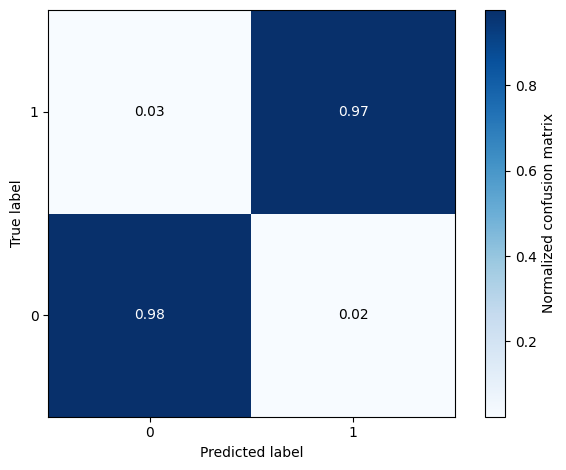

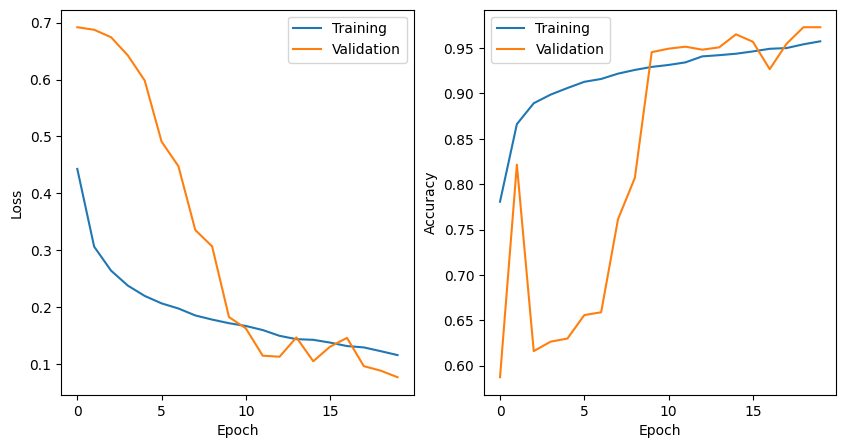

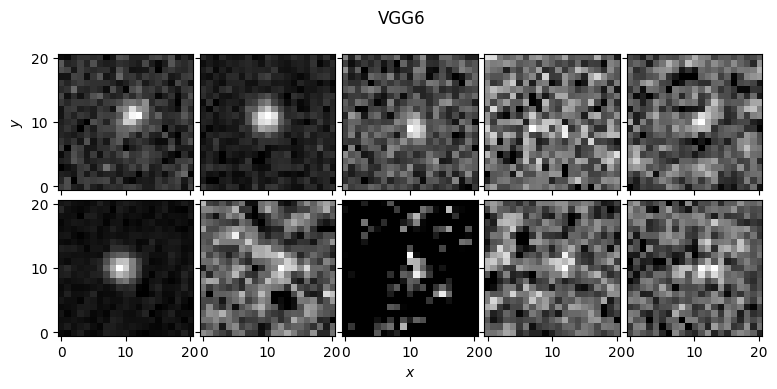

In [33]:
# Implement VGG6 training for 20 epochs (rather than 1)
n_epochs = 20
batch_size = 1024

vgg_model_history = vgg_model.fit(
    data_train,
    class_train,
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=0,
    validation_data=(data_val, class_val),
    shuffle=True,
)
classes = vgg_model.predict(data_test, verbose=0)

# plot the confusion matrix

plot_confusion_matrix(np.argmax(class_test, axis=1), np.argmax(classes, axis=1), normalize=True)
# plot the training history
plot_model_history(vgg_model_history)
# plot example classifications with plot_image_array
plot_image_array(data_test, class_true=class_test, classes=classes, title="VGG6")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


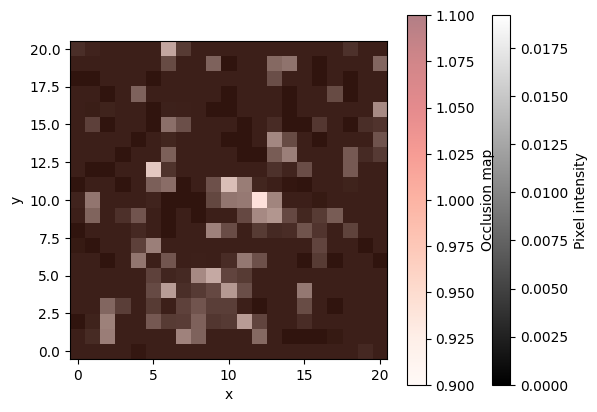

In [34]:
model = vgg_model
image_number = 15

kernel_size = 5
input_stamp = data_test[image_number].reshape(21, 21)
i = 0
j = 0
heatmap = []
keras_stamps = []
for j in range(22 - kernel_size):
    for i in range(22 - kernel_size):
        img = np.copy(input_stamp)
        img[i : i + kernel_size, j : j + kernel_size] = 0
        img = normalize_image(img)
        keras_stamps.append(img)
keras_stamps = np.array(keras_stamps).reshape([-1, 21, 21, 1])
probs = 1.0 - model.predict(keras_stamps)
heatmap = probs[:, 1].reshape(22 - kernel_size, 22 - kernel_size)


def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:, -1] = np.linspace(0, 0.8, N + 4)
    return mycmap


# pad heatmap to same size as original image
heatmap = np.pad(heatmap, pad_width=int(kernel_size / 2), mode="minimum")

# use the base cmap to create transparent overlay
mycmap = transparent_cmap(plt.cm.Reds)
fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(data_test[image_number].reshape(21, 21), cmap="gray", origin="lower")
heatmap_im = ax.imshow(np.array(heatmap), alpha=0.5, cmap=mycmap, origin="lower")
ax.set_ylabel("y")
ax.set_xlabel("x")
cbar = plt.colorbar(im)
cbar_heatmap = plt.colorbar(heatmap_im)
cbar.set_label("Pixel intensity")
cbar_heatmap.set_label("Occlusion map")
plt.show()

In [11]:
# Based on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
from tensorflow.keras.layers import (
    Input,
    Add,
    Dense,
    Activation,
    ZeroPadding2D,
    BatchNormalization,
    Flatten,
    Conv2D,
    AveragePooling2D,
    MaxPooling2D,
    GlobalMaxPooling2D,
)
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

K.set_image_data_format("channels_last")


def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(
        filters=F1,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="valid",
        name=conv_name_base + "2a",
        kernel_initializer=glorot_uniform(seed=0),
    )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(
        filters=F2,
        kernel_size=(f, f),
        strides=(1, 1),
        padding="same",
        name=conv_name_base + "2b",
        kernel_initializer=glorot_uniform(seed=0),
    )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2b")(X)
    X = Activation("relu")(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(
        filters=F3,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="valid",
        name=conv_name_base + "2c",
        kernel_initializer=glorot_uniform(seed=0),
    )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2c")(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X


def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + "2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(
        filters=F2,
        kernel_size=(f, f),
        strides=(1, 1),
        padding="same",
        name=conv_name_base + "2b",
        kernel_initializer=glorot_uniform(seed=0),
    )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2b")(X)
    X = Activation("relu")(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(
        filters=F3,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="valid",
        name=conv_name_base + "2c",
        kernel_initializer=glorot_uniform(seed=0),
    )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2c")(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(
        filters=F3,
        kernel_size=(1, 1),
        strides=(s, s),
        padding="valid",
        name=conv_name_base + "1",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + "1")(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X


def ResNet50(input_shape=(21, 21, 1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name="conv1", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block="a", s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block="b")
    X = identity_block(X, 3, [64, 64, 256], stage=2, block="c")

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block="a", s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block="b")
    X = identity_block(X, 3, [128, 128, 512], stage=3, block="c")
    X = identity_block(X, 3, [128, 128, 512], stage=3, block="d")

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block="a", s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block="b")
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block="c")
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block="d")
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block="e")
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block="f")

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block="a", s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block="b")
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block="c")

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc" + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model

Epoch 1/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 106s 161ms/step - accuracy: 0.9206 - loss: 0.3498 - val_accuracy: 0.4522 - val_loss: 5.0195
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.9914 - loss: 0.0242 - val_accuracy: 0.4522 - val_loss: 3.1355
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9933 - loss: 0.0186 - val_accuracy: 0.4522 - val_loss: 70.6259
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9937 - loss: 0.0182 - val_accuracy: 0.4522 - val_loss: 36.1098
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.9960 - loss: 0.0117 - val_accuracy: 0.4522 - val_loss: 6.7622
685/685 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


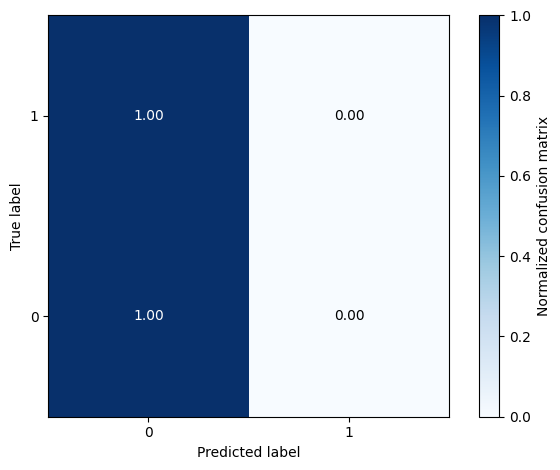

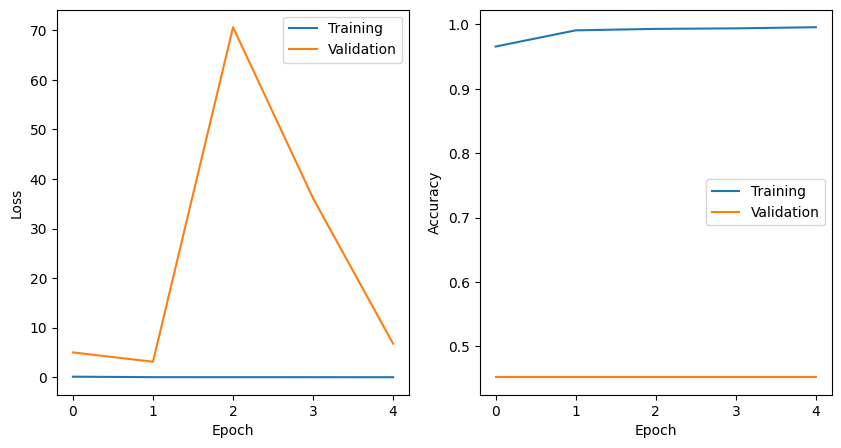

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),  # Must be a NumPy array
    y=np.argmax(class_train, axis=1)  # Convert one-hot labels to class indices
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Train ResNet50 with categorical cross-entropy loss for 5 epochs and a batch size of 256
resnet_model = ResNet50(input_shape=(21, 21, 1), classes=2)

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=["accuracy"]
)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
data_train_resampled, class_train_resampled = ros.fit_resample(
    data_train.reshape(len(data_train), -1),
    np.argmax(class_train, axis=1)
)

# Reshape back and one-hot encode
data_train = data_train_resampled.reshape(-1, 21, 21, 1)
class_train = tf.keras.utils.to_categorical(class_train_resampled, num_classes=2)


# Train the model with class weights
resnet_model_history = resnet_model.fit(
    data_train,
    class_train,
    epochs=5,
    batch_size=256,
    verbose=1,
    validation_data=(data_val, class_val),
    shuffle=True,
    class_weight=class_weight_dict  # Apply class weights here
)

# Make predictions
raw_preds = resnet_model.predict(data_test, verbose=1)

# Plot confusion matrix
plot_confusion_matrix(np.argmax(class_test, axis=1), np.argmax(raw_preds, axis=1), normalize=True)

# Plot training history
plot_model_history(resnet_model_history)

In [14]:
print(np.unique(class_train_resampled, return_counts=True))
print(class_weight_dict)


(array([0, 1]), array([42000, 42000]))
{0: 1.1057983556901774, 1: 0.9126785714285715}
